<a href="https://colab.research.google.com/github/87tana/Image-Semantic-Segmentation/blob/main/Tumor_Semantic_Segmentation_modif.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# 1. Set up environment

In [3]:
from google.colab import drive
drive.mount('/content/drive/',force_remount=True)


Mounted at /content/drive/


In [7]:
cd '/content/drive/MyDrive/Project_Experiments/Tumor_Semantic_Segmentation/'

/content/drive/MyDrive/Project_Experiments/Tumor_Semantic_Segmentation


In [8]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim  # Optimization algorithms
from torch.utils.data import DataLoader


from src.utils.utils import read_json, create_mask
from src.dataset.dataset import SegmentationDataset
from src.models.resnetunet import ResNetUNet
from src.utils.transform import transform_img,transform_mask
from src.train import train

# 2. Data Prepration

In [9]:
# Path to dataset
root_dir = '/content/drive/MyDrive/Project_Experiments/Tumor_Semantic_Segmentation/Tumor_Segmentation'

df = read_json(root_dir)
df.head(2)

Annotation is missing for image 1380 in train


,file_name,width,height,category_id,segmentation,subset
0,2256_jpg.rf.3afd7903eaf3f3c5aa8da4bbb928bc19.jpg,640,640,1,"[[313.75, 238.75, 145, 238.75, 145, 401.25, 31...",train
1,2871_jpg.rf.3b6eadfbb369abc2b3bcb52b406b74f2.jpg,640,640,1,"[[342.5, 176.25, 193.75, 176.25, 193.75, 410, ...",train


In [ ]:
subset_counts = df['subset'].value_counts()
subset_counts

subset
train    1501
valid     429
test      215
Name: count, dtype: int64

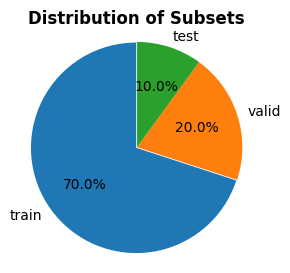

In [ ]:
# Count the occurrences of each subset
subset_counts = df['subset'].value_counts()

explode = (0.01, 0, 0)

plt.figure(figsize=(3, 3))
plt.pie(subset_counts, labels=subset_counts.index, autopct='%1.1f%%',startangle=90, explode=explode)
plt.title('Distribution of Subsets', weight='bold')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

## 2.2 Creating a mask

## 2.3 Data Images Glimpse, Class 1 and Class 2 are both Tumor

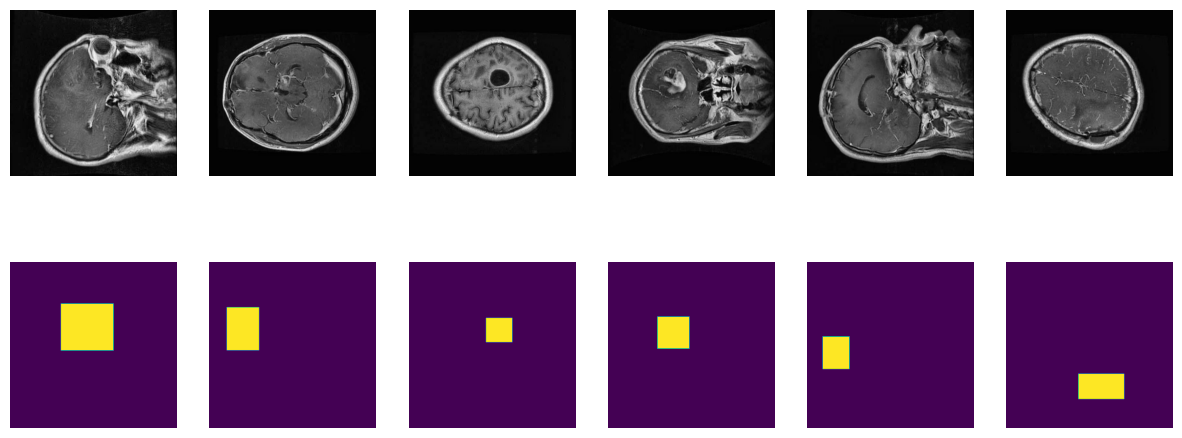

In [ ]:
samp = df[df['category_id']==1].sample(6).reset_index(drop=True)

fig, axes = plt.subplots (2,6,figsize=(15,6))

for i in range(len(samp)): # index and image path
    img = mpimg.imread(os.path.join(root_dir,samp.loc[i]['subset'],samp.loc[i]['file_name']))
    axes[0,i].imshow(img)
    axes[0,i].axis('off') # Turn off axis labels
    mask = create_mask(samp.loc[i])
    axes[1,i].imshow(mask)
    axes[1,i].axis('off') # Turn off axis labels

plt.show()


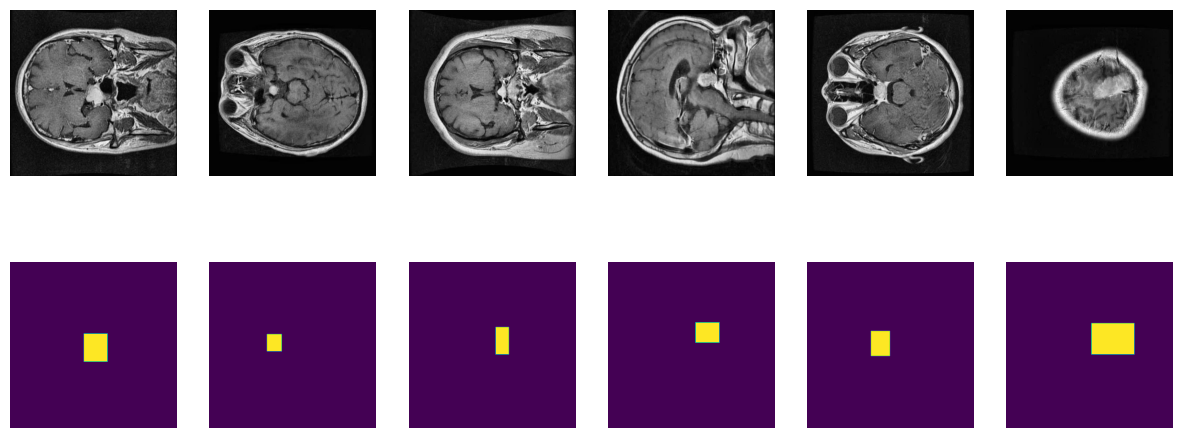

In [ ]:
samp = df[df['category_id']==2].sample(6).reset_index(drop=True)

fig, axes = plt.subplots (2,6,figsize=(15,6))

for i in range(len(samp)): # index and image path
    img = mpimg.imread(os.path.join(root_dir,samp.loc[i]['subset'],samp.loc[i]['file_name']))
    axes[0,i].imshow(img)
    axes[0,i].axis('off') # Turn off axis labels
    mask = create_mask(samp.loc[i])
    axes[1,i].imshow(mask)
    axes[1,i].axis('off') # Turn off axis labels

plt.show()

## 3.Dataset Class

## 5.Creating train, validation dataloaders

In [13]:
"""
Create train and validation dataloaders.
"""

transform = {'image': transform_img , 'mask': transform_mask}

# Train dataloader
train_dataset = SegmentationDataset(root_dir=root_dir, df=df[df['subset']=='train'].reset_index(drop=True), subset='train', max_samp=224, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# Validation dataloader.
valid_dataset = SegmentationDataset(root_dir=root_dir, df=df[df['subset']=='valid'].reset_index(drop=True), subset='valid', max_samp=50, transform=transform)
valid_loader = DataLoader(valid_dataset, batch_size=25, shuffle=False)


valid: 100%|██████████| 50/50 [00:45<00:00,  1.09it/s]


## 7. Model Initialization, loss, Optimizer

evaluate the difference between the predicted segmentation mask and the ground truth mask.
Common loss functions for segmentation tasks include the Dice loss, cross-entropy loss, and focal loss.

During training, the CNN updates its weights to minimize the difference between the predicted segmentation mask and the ground truth mask.

In [ ]:
import torch.nn.functional as F
class DiceLoss(nn.Module):
    def __init__(self, smooth=1.0):
        super(DiceLoss, self).__init__()
        self.smooth = smooth

    def forward(self, y_pred, y_true):
        # Apply sigmoid to get probabilities if logits are provided
        y_pred = torch.sigmoid(y_pred)

        # Flatten label and prediction tensors
        y_pred_flat = y_pred.view(-1)
        y_true_flat = y_true.view(-1)

        # Compute the intersection and the union
        intersection = (y_pred_flat * y_true_flat).sum()
        union = y_pred_flat.sum() + y_true_flat.sum()

        # Compute Dice score
        dice_score = (2. * intersection + self.smooth) / (union + self.smooth)

        # Dice loss is 1 - Dice score
        dice_loss = 1 - dice_score

        return dice_loss


## 8. PyTorch Setup for Training Loop with GPU Compatibility

In [14]:
# Initialize the model, loss function, and optimizer

model = ResNetUNet()
#criterion = DiceLoss()
criterion = nn.BCEWithLogitsLoss()  # This loss combines a Sigmoid layer and the BCELoss in one single class.
#criterion = nn.BCELoss()

optimizer = optim.Adam(model.parameters(), lr=0.000001)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 160MB/s]


In [15]:
# Set the max number of epochs, and validation step.
num_epochs = 200
valid_step = 5
ckpt_step = 5
# Set the device to GPU if availabel
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Move the model to the device.
exp_id ='exp_5'

## 9. Training

In [16]:
train(model,
      optimizer,
      criterion,
      num_epochs,
      train_loader,
      valid_loader,
      ckpt_step,
      valid_step,
      device,
      exp_id,
      resume_ckp = None)

Epoch [1/200], Loss: 0.6923
Average Valid Loss: 0.6929
Epoch [2/200], Loss: 0.6890
Epoch [3/200], Loss: 0.6858
Epoch [4/200], Loss: 0.6828
Epoch [5/200], Loss: 0.6799
Epoch [6/200], Loss: 0.6770
Average Valid Loss: 0.6758
Epoch [7/200], Loss: 0.6742
Epoch [8/200], Loss: 0.6714
Epoch [9/200], Loss: 0.6687
Epoch [10/200], Loss: 0.6659
Epoch [11/200], Loss: 0.6630
Average Valid Loss: 0.6622
Epoch [12/200], Loss: 0.6601
Epoch [13/200], Loss: 0.6570
Epoch [14/200], Loss: 0.6538
Epoch [15/200], Loss: 0.6503
Epoch [16/200], Loss: 0.6466
Average Valid Loss: 0.6447
Epoch [17/200], Loss: 0.6427
Epoch [18/200], Loss: 0.6385
Epoch [19/200], Loss: 0.6341
Epoch [20/200], Loss: 0.6292
Epoch [21/200], Loss: 0.6241
Average Valid Loss: 0.6215
Epoch [22/200], Loss: 0.6187
Epoch [23/200], Loss: 0.6129
Epoch [24/200], Loss: 0.6067
Epoch [25/200], Loss: 0.6002
Epoch [26/200], Loss: 0.5932
Average Valid Loss: 0.5900
Epoch [27/200], Loss: 0.5858
Epoch [28/200], Loss: 0.5779
Epoch [29/200], Loss: 0.5696
Epoch 

In [ ]:
x = torch.randn(1, 3, 640, 640).cuda()  # Batch size 1, single channel image of size 80x80
output = model(x)
print("Output shape:", output.shape)

Output shape: torch.Size([1, 1, 320, 320])


In [ ]:
torch.cuda.empty_cache()

Text(0.5, 0.98, 'Training and Validation Loss Curves')

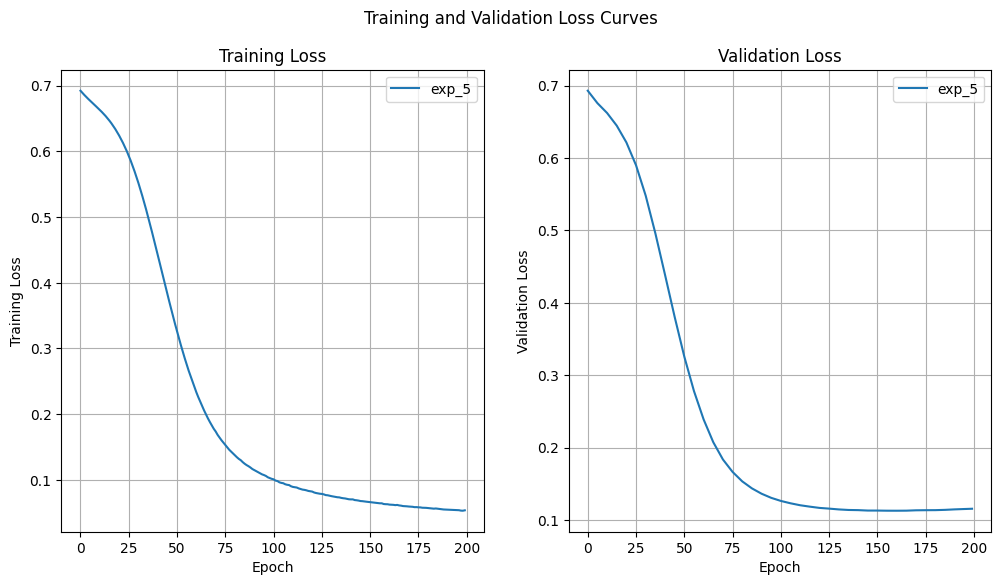

In [17]:
"""
Plot train and validation curves
"""

exp_ids = ['exp_5']
xlim_ = 5
ylim_ = 0.1

fig, axes = plt.subplots (1,2,figsize=(12,6))

for exp in exp_ids:

  in_path = os.path.join('Model_Checkpoints',exp,'loss_log.npy')
  loss_log = np.load(in_path, allow_pickle=True).item()
  train_loss = loss_log['train']
  valid_loss = loss_log['valid']

  axes[0].plot(np.vstack(train_loss)[:,0],np.vstack(train_loss)[:,1]) #vertically stack the array---- (train_loss) contains elements of [epoch, epoch_loss] --> 10 0utput because we have 10.
  axes[1].plot(np.vstack(valid_loss)[:,0],np.vstack(valid_loss)[:,1])




#axes[0].set_xlim(0, xlim_)
#axes[1].set_xlim(0, xlim_)
#axes[0].set_ylim(0, ylim_)
#axes[1].set_ylim(0, ylim_)

axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Training Loss')
axes[0].set_title('Training Loss')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Validation Loss')
axes[1].set_title('Validation Loss')
axes[0].grid(True)
axes[1].grid(True)
axes[0].legend(exp_ids)
axes[1].legend(exp_ids)

fig.suptitle('Training and Validation Loss Curves')


In [18]:
def accuracy(groundtruth_mask, pred_mask):
    intersect = np.sum(pred_mask*groundtruth_mask)
    union = np.sum(pred_mask) + np.sum(groundtruth_mask) - intersect
    xor = np.sum(groundtruth_mask==pred_mask)
    acc = np.mean(xor/(union + xor - intersect))
    return round(acc, 3)

def precision_score_(groundtruth_mask, pred_mask):
    intersect = np.sum(pred_mask*groundtruth_mask)
    total_pixel_pred = np.sum(pred_mask)
    precision = np.mean(intersect/total_pixel_pred)
    return round(precision, 3)

def recall_score_(groundtruth_mask, pred_mask):
    intersect = np.sum(pred_mask*groundtruth_mask)
    total_pixel_truth = np.sum(groundtruth_mask)
    recall = np.mean(intersect/total_pixel_truth)
    return round(recall, 3)

def dice_coef(groundtruth_mask, pred_mask):
    intersect = np.sum(pred_mask*groundtruth_mask)
    total_sum = np.sum(pred_mask) + np.sum(groundtruth_mask)
    dice = np.mean(2*intersect/total_sum)
    return round(dice, 3) #round up to 3 decimal places

def iou(groundtruth_mask, pred_mask):
    intersect = np.sum(pred_mask*groundtruth_mask)
    union = np.sum(pred_mask) + np.sum(groundtruth_mask) - intersect
    iou = np.mean(intersect/union)
    return round(iou, 3)

IoU:0.32, Acc:0.98, Dice:0.48, Precision:0.62, Recall:0.40


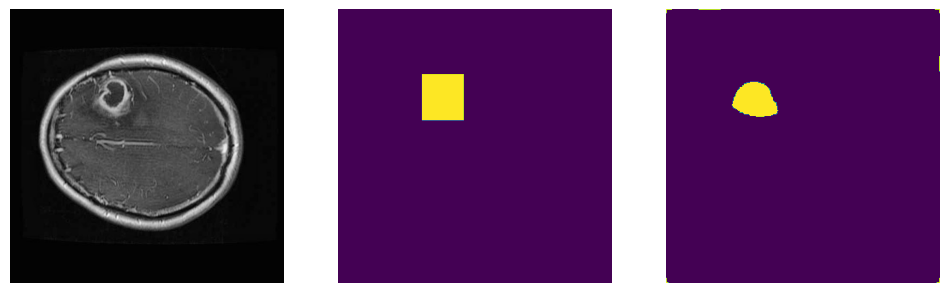

In [19]:
"""
Visualize sample validation result.
"""

#model = ResNetUNet()


# Load the trained model
ckp_path = os.path.join('Model_Checkpoints','exp_5','ckp_199.pt')
checkpoint = torch.load(ckp_path)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()
sigmoid = nn.Sigmoid()  # If the model does not have embedded sigmoid

idx=32

mask = valid_dataset.data_[idx]['mask']
mask = valid_dataset.transform['mask'](mask).squeeze(0).numpy()
mask[mask>0] = 1.0

image = valid_dataset.data_[idx]['image']
img = valid_dataset.transform['image'](image)
img = img.unsqueeze(0)
img = img.to(device)
with torch.no_grad():
  pred = model(img)
pred = pred.squeeze(0)
pred = pred.squeeze(0)
pred = sigmoid(pred).cpu().numpy()

thresh=0.2
pred[pred>thresh]=1.0
pred[pred<=thresh]=0.0


iou_val = iou(mask, pred)
acc_val = accuracy(mask, pred)
dice_val = dice_coef(mask, pred)
prec_val = precision_score_(mask, pred)
rec_val = recall_score_(mask, pred)

print('IoU:{:.2f}, Acc:{:.2f}, Dice:{:.2f}, Precision:{:.2f}, Recall:{:.2f}'.format(iou_val,acc_val,dice_val,prec_val,rec_val))


# Plot the image, mask, and prediction
fig, axes = plt.subplots (1,3,figsize=(12,6))
axes[0].imshow(image)
axes[1].imshow(mask)
axes[2].imshow(pred)

for i in range(3):
  axes[i].axis('off')


In [24]:

# Load the trained model
ckp_path = os.path.join('Model_Checkpoints','exp_5','ckp_199.pt')
checkpoint = torch.load(ckp_path)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()
sigmoid = nn.Sigmoid()  # If the model does not have embedded sigmoid

thresh=0.2   #convert prediction from probability into a category

iou_val = []
acc_val = []
dice_val = []
prec_val = []
rec_val = []

for idx in tqdm(range(valid_dataset.__len__())):

  image = valid_dataset.data_[idx]['image']
  mask = valid_dataset.data_[idx]['mask']

  mask = valid_dataset.transform['mask'](mask).squeeze(0).numpy()
  mask[mask>0] = 1.0

  img = valid_dataset.transform['image'](image)
  img = img.unsqueeze(0)
  img = img.to(device)
  with torch.no_grad():
    pred = model(img)
  pred = pred.squeeze(0)
  pred = pred.squeeze(0)
  pred = sigmoid(pred).cpu().numpy()


  pred[pred>thresh]= 1.0
  pred[pred<=thresh]= 0.0

  iou_val.append(iou(mask, pred))
  acc_val.append(accuracy(mask, pred))
  dice_val.append(dice_coef(mask, pred))
  prec_val.append(precision_score_(mask, pred))
  rec_val.append(recall_score_(mask, pred))

iou_val = np.mean(iou_val)
acc_val = np.mean(acc_val)
dice_val = np.mean(dice_val)
prec_val = np.mean(prec_val)
rec_val = np.mean(rec_val)

print('\nIoU:{:.2f}, Acc:{:.2f}, Dice:{:.2f}, Precision:{:.2f}, Recall:{:.2f}'.format(iou_val,acc_val,dice_val,prec_val,rec_val))


100%|██████████| 50/50 [00:00<00:00, 123.39it/s]


IoU:0.30, Acc:0.96, Dice:0.42, Precision:0.44, Recall:0.50
